In [1]:
import scipy.io as sio
import numpy as np
from sklearn import manifold
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import pairwise_distances
import import_ipynb
from manifold_learning_graph_kernels import ShortestPathKernel
from sklearn.decomposition import PCA

importing Jupyter notebook from manifold_learning_graph_kernels.ipynb


In [2]:
import import_ipynb
from manifold_learning_graph_kernels import ShortestPathKernel
from manifold_learning_graph_kernels import fit_n_components

In [3]:
ppi = sio.loadmat("PPI.mat")

In [4]:
# G contains a vector of cells, one per graph
ppi_graphs = ppi['G'][0] # get graphs
# The entry am of each cell is the adjacency matrix of the graph. 
# The variable labels, contains the class-labels of each graph. 
ppi_lb = ppi['labels']
ppi_labels = ppi['labels'].ravel()

1 let dist be a |V| × |V| array of minimum distances initialized to ∞ (infinity)
2 for each edge (u,v)
3    dist[u][v] ← w(u,v)  // the weight of the edge (u,v)
4 for each vertex v
5    dist[v][v] ← 0
6 for k from 1 to |V|
7    for i from 1 to |V|
8       for j from 1 to |V|
9          if dist[i][j] > dist[i][k] + dist[k][j] 
10             dist[i][j] ← dist[i][k] + dist[k][j]
11         end if


In [5]:
sp_kernel = ShortestPathKernel()

In [6]:
SP_graphs = sp_kernel.compute_multi_shortest_paths(ppi_graphs[:]['am'])

In [7]:
K = sp_kernel.compute_multi_graphs_kernel(SP_graphs)

In [8]:
D = pairwise_distances(K, metric='euclidean',n_jobs=4)

In [9]:
import matplotlib.pyplot as plt
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();
plt.show()

<Figure size 640x480 with 2 Axes>

# SVM Linear Classifier

In [10]:
from sklearn.model_selection import StratifiedKFold
strat_k_fold = StratifiedKFold(n_splits = 10, shuffle = True) #10

In [11]:
clf = SVC(kernel="linear", C = 1.0)
Y = ppi_lb.ravel()

In [12]:
scores_ln = cross_val_score(clf, D, Y, cv = strat_k_fold, n_jobs= 8)
print(str(np.min(scores_ln)) +" - "+str(np.mean(scores_ln))+ " - " + str(np.max(scores_ln)) + " - "+ str(np.std(scores_ln)))

0.6666666666666666 - 0.7569444444444444 - 0.875 - 0.05667279378639769


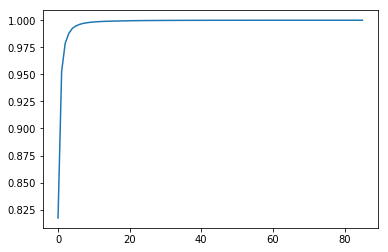

array([0.8173237 , 0.95259178, 0.97873774])

In [13]:

PCA_D = PCA(n_components = 2).fit_transform(D)
plt.plot(np.cumsum(PCA().fit(D).explained_variance_ratio_))
plt.show()
np.cumsum(PCA().fit(D).explained_variance_ratio_)[:3]

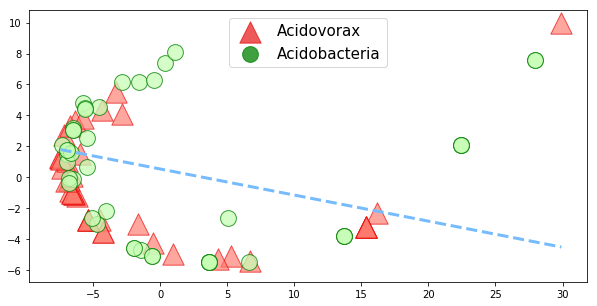

In [14]:
acidovorax = PCA_D[ppi_labels == 1]
acidobacteria = PCA_D[ppi_labels == 2]

clf = clf.fit(PCA_D, ppi_labels)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min(PCA_D), np.max(PCA_D))
yy = a * xx - (clf.intercept_[0]) / w[1]

plt.figure(figsize=(10,5))


ax_av = plt.scatter(acidovorax[:, 0], acidovorax[:, 1], color = "xkcd:red", marker = "^",label = "Acidovorax", s = 455, alpha = 0.65) 
ax_ab = plt.scatter(acidobacteria[:, 0], acidobacteria[:, 1], color = "green", label = "Acidobacteria",  s = 250, alpha = 0.75)
svm_line = plt.plot(xx, yy, color = "xkcd:sky blue", linestyle = "--", linewidth = 3.0)

plt.axis('tight');
#plt.grid(True)
plt.legend(prop={'size': 15})

ax_av.set_facecolor('xkcd:salmon')
ax_ab.set_facecolor('xkcd:pale green')

plt.show()


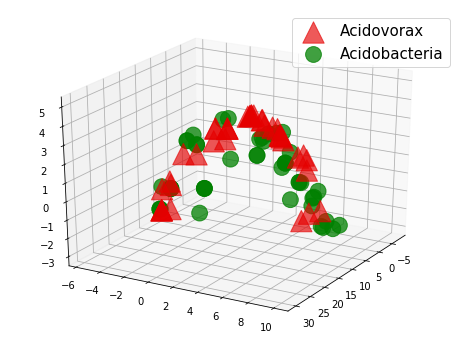

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

PCA_D = PCA(n_components = 3).fit_transform(D)

acidovorax = PCA_D[ppi_labels == 1]
acidobacteria = PCA_D[ppi_labels == 2]

clf = clf.fit(PCA_D, ppi_labels)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min(PCA_D), np.max(PCA_D))
yy = a * xx - (clf.intercept_[0]) / w[1]

#plt.figure(figsize=(10,5))


ax_av = ax.scatter(acidovorax[:, 0], acidovorax[:, 1], acidovorax[:, 2],c = "xkcd:red", marker = "^",label = "Acidovorax", s = 455, alpha = 0.65) 
ax_ab = ax.scatter(acidobacteria[:, 0], acidobacteria[:, 1], acidobacteria[:, 2], c = "green", label = "Acidobacteria",  s = 250, alpha = 0.75)
#svm_line = plt.plot(xx, yy, color = "xkcd:sky blue", linestyle = "--", linewidth = 3.0)

plt.axis('tight');
#plt.grid(True)
plt.legend(prop={'size': 15})

ax_av.set_facecolor('xkcd:salmon')
ax_ab.set_facecolor('xkcd:pale green')
ax.view_init(azim = 30, elev = 25)
plt.show()


#  Manifold Learning Isomap

In [16]:
n_neighbors = 15
n_components = 2
iso_prj_D = manifold.Isomap(n_neighbors, n_components).fit_transform(D)

In [17]:
clf = SVC(kernel="linear", C = 1.0)
scores_ln = cross_val_score(clf, iso_prj_D, Y, cv = 10, n_jobs= 8)

np.mean(scores_ln)

0.675

### Plots for Isomap

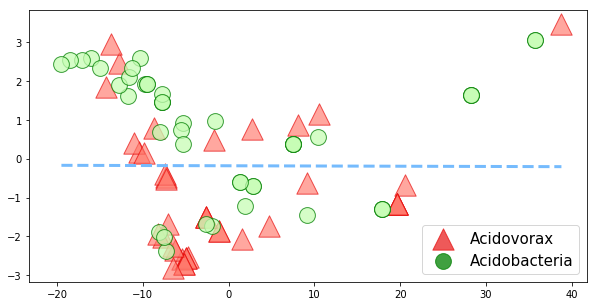

In [18]:
acidovorax = iso_prj_D[ppi_labels == 1]
acidobacteria = iso_prj_D[ppi_labels == 2]

clf = clf.fit(iso_prj_D, ppi_labels)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min(iso_prj_D), np.max(iso_prj_D))
yy = a * xx - (clf.intercept_[0]) / w[1]

plt.figure(figsize=(10,5))


ax_av = plt.scatter(acidovorax[:, 0], acidovorax[:, 1], color = "xkcd:red", marker = "^",label = "Acidovorax", s = 455, alpha = 0.65) 
ax_ab = plt.scatter(acidobacteria[:, 0], acidobacteria[:, 1], color = "green", label = "Acidobacteria",  s = 250, alpha = 0.75)
svm_line = plt.plot(xx, yy, color = "xkcd:sky blue", linestyle = "--", linewidth = 3.0)

plt.axis('tight');
#plt.grid(True)
plt.legend(prop={'size': 15})

ax_av.set_facecolor('xkcd:salmon')
ax_ab.set_facecolor('xkcd:pale green')

plt.show()


#### Fit with best n of components

In [19]:
n_neighbors = 4
opt_n_components = fit_n_components(D, ppi_labels, manifold.Isomap, n_neighbors)
opt_n_components

18

In [20]:
opt_iso_prj_D = manifold.Isomap(4, 18).fit_transform(D)

In [21]:
scores_ln = cross_val_score(clf, opt_iso_prj_D, ppi_labels, cv = strat_k_fold)
np.mean(scores_ln)

0.7680555555555555

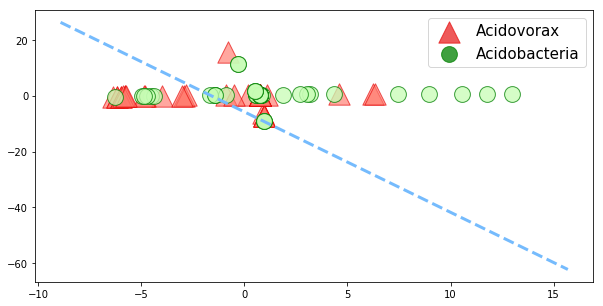

In [22]:
PCA_D = PCA(n_components = 2).fit_transform(opt_iso_prj_D)
clf = SVC(kernel="linear", C = 1.0)

acidovorax = PCA_D[ppi_labels == 1]
acidobacteria = PCA_D[ppi_labels == 2]

clf = clf.fit(PCA_D, ppi_labels)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min(PCA_D), np.max(PCA_D))
yy = a * xx - (clf.intercept_[0]) / w[1]

plt.figure(figsize=(10,5))


ax_av = plt.scatter(acidovorax[:, 0], acidovorax[:, 1], color = "xkcd:red", marker = "^",label = "Acidovorax", s = 455, alpha = 0.65) 
ax_ab = plt.scatter(acidobacteria[:, 0], acidobacteria[:, 1], color = "green", label = "Acidobacteria",  s = 250, alpha = 0.75)
svm_line = plt.plot(xx, yy, color = "xkcd:sky blue", linestyle = "--", linewidth = 3.0)

plt.axis('tight');
#plt.grid(True)
plt.legend(prop={'size': 15})

ax_av.set_facecolor('xkcd:salmon')
ax_ab.set_facecolor('xkcd:pale green')

plt.show()


#  Manifold Learning LocalLinearEmbedding

In [23]:
n_neighbors = 2
n_components = 15
lle_prj_D = manifold.LocallyLinearEmbedding(n_neighbors, n_components).fit_transform(D)

In [24]:
clf = SVC(kernel="linear", C = 1.0)
scores_ln = cross_val_score(clf, lle_prj_D, Y, cv = 10, n_jobs= 8)
np.mean(scores_ln)

0.7208333333333334

### Plots for LLE

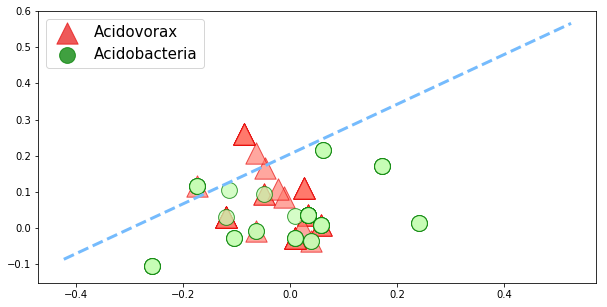

In [25]:
acidovorax = lle_prj_D[ppi_labels == 1]
acidobacteria = lle_prj_D[ppi_labels == 2]

clf = clf.fit(lle_prj_D, ppi_labels)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min(lle_prj_D),np.max(lle_prj_D))
yy = a * xx - (clf.intercept_[0]) / w[1]
plt.figure(figsize=(10,5))


ax_av = plt.scatter(acidovorax[:, 0], acidovorax[:, 1], color = "xkcd:red", marker = "^",label = "Acidovorax", s = 455, alpha = 0.65) 
ax_ab = plt.scatter(acidobacteria[:, 0], acidobacteria[:, 1], color = "green", label = "Acidobacteria",  s = 250, alpha = 0.75)
svm_line = plt.plot(xx, yy, color = "xkcd:sky blue", linestyle = "--", linewidth = 3.0)

plt.axis('tight');
#plt.grid(True)
plt.legend(prop={'size': 15})

ax_av.set_facecolor('xkcd:salmon')
ax_ab.set_facecolor('xkcd:pale green')

plt.show()


#### Fit with best n of components

In [26]:
n_neighbors = 1
opt_n_components = fit_n_components(D, ppi_labels, manifold.LocallyLinearEmbedding, n_neighbors)
opt_n_components

18

In [27]:
opt_lle_prj_D = manifold.LocallyLinearEmbedding(n_neighbors, opt_n_components).fit_transform(D)

In [28]:
scores_ln = cross_val_score(clf, opt_lle_prj_D, ppi_labels, cv = 10)
np.mean(scores_ln)

0.7791666666666666

# Randomized Search

In [29]:
def Linear_SVC_Rand(D, Y, parameters, kfold, n, n_thread = 4, n_components = 2):
    param_grid = {'C': parameters[0], 'kernel': parameters[1]}
    k = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=0)
    clf = SVC()
    randsearch = RandomizedSearchCV(clf, param_distributions=param_grid, cv=k, n_jobs = n_thread, verbose=1, n_iter=n)
    return randsearch.fit(opt_lle_prj_D,Y)

In [30]:
param_test_c = list(range(1,10))
param_test_c.extend([i/10 for i in range(1,10)])
param_test_k = ['linear', 'rbf', 'poly']

In [31]:
clf = Linear_SVC_Rand(opt_lle_prj_D, Y, [param_test_c, param_test_k], kfold = 10, n = 20)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


In [32]:
print(clf.best_params_)
print(clf.best_score_)

{'kernel': 'rbf', 'C': 8}
0.7790697674418605


## Graph Plots

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

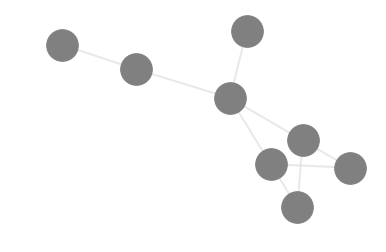

In [34]:
G = nx.from_numpy_matrix(ppi_graphs[6]['am'])
#pos=nx.spring_layout(G) # positions for all nodes
pos = nx.spring_layout(G, k = 0.9, iterations = 1000)
nx.draw_networkx_nodes(G, pos, with_labels= False, node_color = "grey", node_size = 1000, alpha = 1)
nx.draw_networkx_edges(G, pos, width = 2, alpha=0.5,edge_color='lightgrey')
plt.axis('off')
plt.savefig("acidovorax_graph_6am.png", dpi = 250) # save as png
plt.show() # display